# Imports

In [225]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import scale
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.svm import SVC
from sklearn import preprocessing
from collections import Counter
from pprint import pprint
import numpy as np

In [226]:
mnist_data = pd.read_csv('mnist.csv').values

# Test Image Plotting

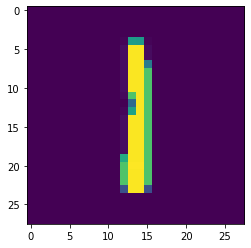

In [227]:
labels = mnist_data[:, 0]
digits = mnist_data[:, 1:]
img_size = 28
plt.imshow(digits[2].reshape(img_size, img_size))
plt.show()

# 1. Data Exploration

In [228]:
label_counts = Counter(labels)
label_percentages = {label: count/len(labels) for label, count in label_counts.items()}
pprint(label_counts)
print()
pprint(label_percentages)

Counter({1: 4684,
         7: 4401,
         3: 4351,
         9: 4188,
         2: 4177,
         6: 4137,
         0: 4132,
         4: 4072,
         8: 4063,
         5: 3795})

{0: 0.09838095238095237,
 1: 0.11152380952380953,
 2: 0.09945238095238096,
 3: 0.1035952380952381,
 4: 0.09695238095238096,
 5: 0.09035714285714286,
 6: 0.0985,
 7: 0.10478571428571429,
 8: 0.09673809523809523,
 9: 0.09971428571428571}


In [229]:
from collections import defaultdict

pixel_avg = defaultdict(float)
for i in range(len(digits[0, :])):
    pixel_avg[i] = sum(digits[:, i])/len(digits[:, i])
    
pixel_avg_list = [pixel_avg[i] for i in range(784)]

In [230]:
pprint(pixel_avg)

useless_pixels = [i for i, avg in pixel_avg.items() if avg == 0.0]
print(useless_pixels)
print(len(useless_pixels))

defaultdict(<class 'float'>,
            {0: 0.0,
             1: 0.0,
             2: 0.0,
             3: 0.0,
             4: 0.0,
             5: 0.0,
             6: 0.0,
             7: 0.0,
             8: 0.0,
             9: 0.0,
             10: 0.0,
             11: 0.0,
             12: 0.003,
             13: 0.01119047619047619,
             14: 0.005142857142857143,
             15: 0.00021428571428571427,
             16: 0.0,
             17: 0.0,
             18: 0.0,
             19: 0.0,
             20: 0.0,
             21: 0.0,
             22: 0.0,
             23: 0.0,
             24: 0.0,
             25: 0.0,
             26: 0.0,
             27: 0.0,
             28: 0.0,
             29: 0.0,
             30: 0.0,
             31: 0.0,
             32: 0.00038095238095238096,
             33: 0.0013095238095238095,
             34: 0.010547619047619047,
             35: 0.02726190476190476,
             36: 0.050904761904761904,
             37: 0.0664047

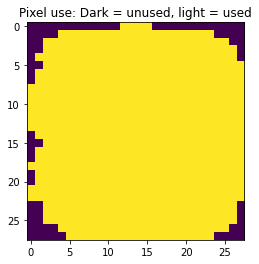

In [231]:
example_useless_pixels = np.array([1 if i not in useless_pixels else 0 for i in range(784)])
plt.imshow(example_useless_pixels.reshape(img_size, img_size))
plt.title("Pixel use: Dark = unused, light = used")
plt.show()

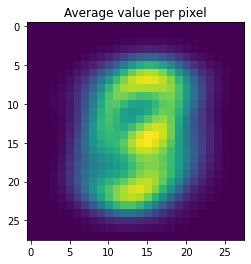

In [232]:
plt.imshow(np.array(pixel_avg_list).reshape(img_size, img_size))
plt.title("Average value per pixel")
plt.show()

## 2. Ink feature and first model

In [269]:
# create ink feature

ink = np.array([sum(row) for row in digits])

# compute mean for each digit class
ink_mean = [np.mean(ink[labels == i]) for i in range(10)]

# compute standard deviation for each digit class
ink_std = [np.std(ink[labels == i]) for i in range(10)]

# The reshape is neccesary to call LogisticRegression() with a single feature
ink = scale(ink).reshape(-1, 1)

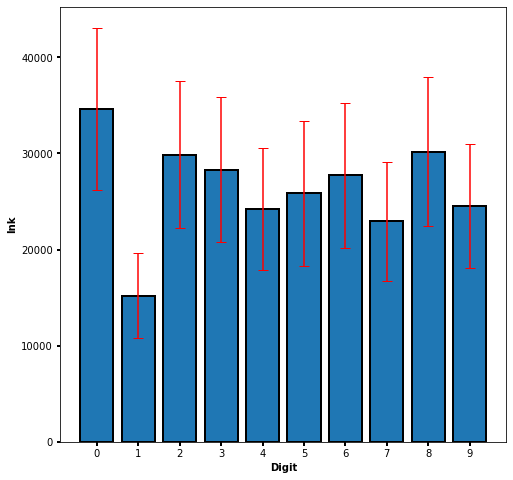

In [327]:
x = [i for i in range(10)]

fig, ax = plt.subplots(figsize=(8,8))


plt.bar(x, ink_mean, edgecolor='black', linewidth=2)
plt.errorbar(x, ink_mean, yerr=ink_std, color='r', capsize=5, ls='none')
ax.tick_params(width=2)
plt.xlabel("Digit", fontdict={'weight':'bold'})
plt.ylabel("Ink", fontdict={'weight':'bold'})
plt.xticks(x, x)

plt.show()

In [270]:
model_logreg1 = LogisticRegression(random_state =0).fit(ink,labels)

In [271]:
result_1= model_logreg1.predict(ink)

In [272]:
model_logreg1.score(ink, labels)

0.22680952380952382

In [274]:
from sklearn.metrics import confusion_matrix
cm1 = confusion_matrix(result_1,labels)

Text(69.0, 0.5, 'Truth_Label')

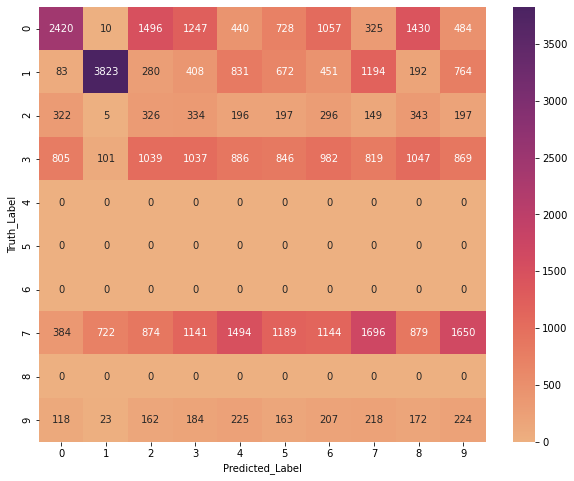

In [312]:
import seaborn as sn
plt.figure(figsize = (10,8))
# were 'cmap' is used to set the accent colour
sn.heatmap(cm1, annot=True, cmap= 'flare',  fmt='d', cbar=True)
plt.xlabel('Predicted_Label')
plt.ylabel('Truth_Label')

# 3. LongestLines Feature "Ratio"

In [238]:
def longest_line_ratio(image):
    """Finds the longest lines horizontally and vertically withi n the digit. Takes their lengths and returns
    a ratio of row_length/column_length. High number means row is longer than column, close to 1 means they are
    roughly the same, close to 0, and column is longer than row"""
    # Assuming continuous 784 pixels
    max_row_length = 0
    max_column_length = 0
    
    # ROW CALCULATION
    for i in range(0, 784, 28): #index 0, 28, 56 etc...
        end_of_row = i + 28
        counter = 0
        
        # 0 ... 28
        for current_pixel in range(i, end_of_row):
            if image[current_pixel] > 0:
                counter += 1
        
        max_row_length = max(counter, max_row_length)
    
    # COLUMN CALCULATION
    for i in range(0, 28): #index 0, 1, 2 ... 28
        end_of_column = i + (28 * 27)
        counter = 0
        
        # 0 ... 28
        for current_pixel in range(i, end_of_column, 28):
            if image[current_pixel] > 0:
                counter += 1
        
        max_column_length = max(counter, max_column_length)
        
    return (max_row_length/max_column_length)

## 4. Ratio feature and second model

In [314]:
ratio = np.array([longest_line_ratio(image) for image in digits])

# compute mean for each digit class
ratio_mean = [np.mean(ratio[labels == i]) for i in range(10)]

# compute standard deviation for each digit class
ratio_std = [np.std(ratio[labels == i]) for i in range(10)]

ratio = scale(ratio).reshape(-1,1)

In [315]:
model_logreg1 = LogisticRegression(random_state =0).fit(ratio,labels)

In [316]:
result_2= model_logreg1.predict(ratio)

In [317]:
model_logreg1.score(ratio, labels)

0.22614285714285715

In [318]:
cm2 = confusion_matrix(result_2,labels)

Text(69.0, 0.5, 'Truth_Label')

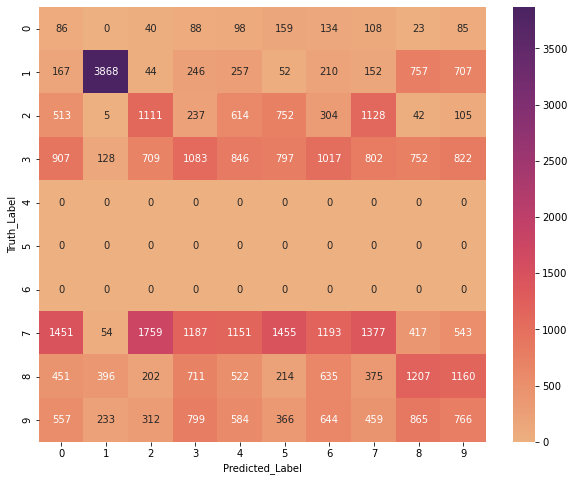

In [319]:
import seaborn as sn
plt.figure(figsize = (10,8))
# were 'cmap' is used to set the accent colour
sn.heatmap(cm2, annot=True, cmap= 'flare',  fmt='d', cbar=True)
plt.xlabel('Predicted_Label')
plt.ylabel('Truth_Label')

# 5. Nonzero pixels feature

In [286]:
def Non_Zero_Pixels(image):
    counter =0
    for i in range(0,784,1):
        if image[i] > 0:
            counter+=1
    return counter

## 6. Third model "nonzero feature"

In [287]:
nonzero= np.array([Non_Zero_Pixels(image) for image in digits])

nonzero_mean = [np.mean(nonzero[labels == i]) for i in range(10)]

# compute standard deviation for each digit class
nonzero_std = [np.std(nonzero[labels == i]) for i in range(10)]

nonzero = scale(nonzero).reshape(-1,1)

In [288]:
model_logreg1 = LogisticRegression(random_state =0).fit(nonzero,labels)

In [289]:
    result_3= model_logreg1.predict(nonzero)

In [290]:
model_logreg1.score(nonzero, labels)

0.25511904761904763

In [291]:
cm3= confusion_matrix(result_3,labels)

Text(69.0, 0.5, 'Truth_Label')

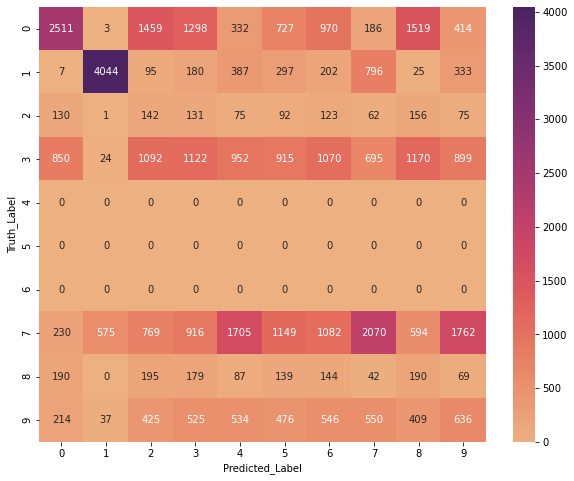

In [320]:
import seaborn as sn
plt.figure(figsize = (10,8))
# were 'cmap' is used to set the accent colour
sn.heatmap(cm3, annot=True, cmap= 'flare',  fmt='d', cbar=True)
plt.xlabel('Predicted_Label')
plt.ylabel('Truth_Label')

## 7. Fourth model "All Features"

In [294]:
ink = scale(ink).reshape(42000,)
ratio = scale(ratio).reshape(42000,)
nonzero = scale(nonzero).reshape(42000,)

In [295]:
import itertools
ratio_list = ratio.tolist()
ink_list = ink.tolist()
nonzero_list = nonzero.tolist()
X= list(itertools.chain.from_iterable(zip(ink_list, ratio_list,nonzero_list)))

In [296]:
X= scale(X).reshape(42000,3)

In [297]:
model_logreg2 = LogisticRegression(random_state =0).fit(X,labels)

In [298]:
result_4=model_logreg2.predict(X)

In [299]:
model_logreg2.score(X, labels)

0.37392857142857144

In [300]:
cm4= confusion_matrix(result_4,labels)

Text(69.0, 0.5, 'Truth_Label')

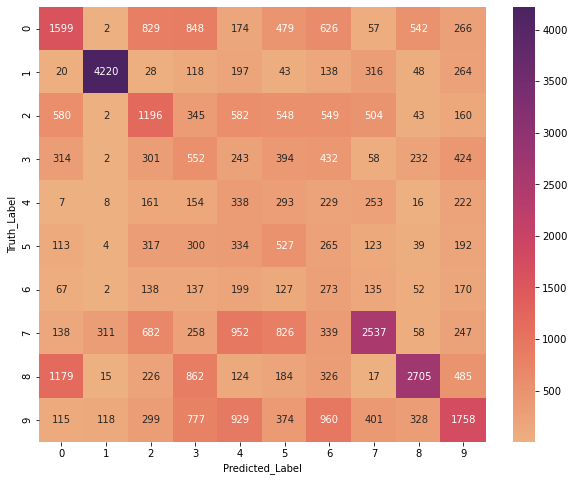

In [321]:
import seaborn as sn
plt.figure(figsize = (10,8))
# were 'cmap' is used to set the accent colour
sn.heatmap(cm4, annot=True, cmap= 'flare',  fmt='d', cbar=True)
plt.xlabel('Predicted_Label')
plt.ylabel('Truth_Label')

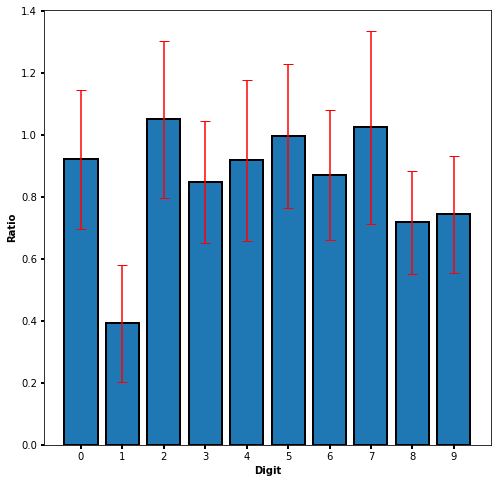

In [328]:
x = [i for i in range(10)]

fig, ax = plt.subplots(figsize=(8,8))


plt.bar(x, ratio_mean, edgecolor='black', linewidth=2)
plt.errorbar(x, ratio_mean, yerr=ratio_std, color='r', capsize=5, ls='none')
ax.tick_params(width=2)
plt.xlabel("Digit", fontdict={'weight':'bold'})
plt.ylabel("Ratio", fontdict={'weight':'bold'})
plt.xticks(x, x)

plt.show()

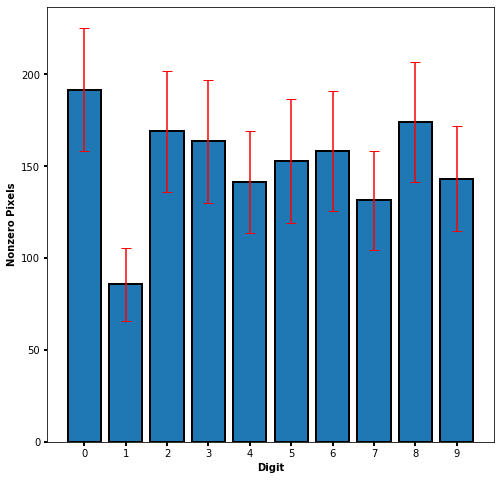

In [329]:
x = [i for i in range(10)]

fig, ax = plt.subplots(figsize=(8,8))


plt.bar(x, nonzero_mean, edgecolor='black', linewidth=2)
plt.errorbar(x, nonzero_mean, yerr=nonzero_std, color='r', capsize=5, ls='none')
ax.tick_params(width=2)
plt.xlabel("Digit", fontdict={'weight':'bold'})
plt.ylabel("Nonzero Pixels", fontdict={'weight':'bold'})
plt.xticks(x, x)

plt.show()

In [256]:
print(ratio_mean[0], "\t", ratio_std[0])
print(ratio_mean[1], "\t", ratio_std[1])
print(ratio_mean[2], "\t", ratio_std[2])
print(ratio_mean[3], "\t", ratio_std[3])
print(ratio_mean[4], "\t", ratio_std[4])
print(ratio_mean[5], "\t", ratio_std[5])
print(ratio_mean[6], "\t", ratio_std[6])
print(ratio_mean[7], "\t", ratio_std[7])
print(ratio_mean[8], "\t", ratio_std[8])
print(ratio_mean[9], "\t", ratio_std[9])

0.9212436292441253 	 0.2239797765457606
0.39261617020544715 	 0.18840575300288148
1.0507165874880846 	 0.25337146859478854
0.8475743832551954 	 0.19704837546936022
0.9177979165379527 	 0.2600374750886837
0.9974284395303374 	 0.23233292743409736
0.8699165361317345 	 0.20888970203455595
1.0238861899338199 	 0.3123663063874526
0.7173429151412142 	 0.16565419629428169
0.7441241503051229 	 0.18879981839926804


# 7. MLR and SVM with training


In [303]:
split = 5000/42000
X_train, X_test, y_train, y_test = train_test_split(digits, labels, train_size = split)

In [304]:
min_max_scaler = preprocessing.MinMaxScaler()

X_train = min_max_scaler.fit_transform(X_train)
X_test = min_max_scaler.transform(X_test)

In [305]:
model_MLR = LogisticRegression(penalty = 'l1', solver = 'liblinear', random_state = 0, max_iter = 10000).fit(X_train, y_train)

In [306]:
result_5 = model_MLR.predict(X_test)
model_MLR.score(X_test, y_test)

0.8955135135135135

In [308]:
cm5=confusion_matrix(result_5,y_test)

Text(69.0, 0.5, 'Truth_Label')

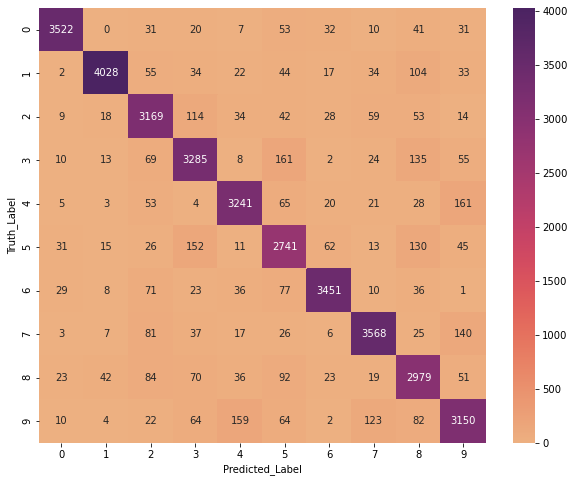

In [323]:
import seaborn as sn
plt.figure(figsize = (10,8))
# were 'cmap' is used to set the accent colour
sn.heatmap(cm5, annot=True, cmap= 'flare',  fmt='d', cbar=True)
plt.xlabel('Predicted_Label')
plt.ylabel('Truth_Label')

In [309]:
%%time
model_SVM = SVC(C= 7).fit(X_train, y_train)
result_6= model_SVM.predict(X_test)
model_SVM.score(X_test, y_test)

Wall time: 5min 40s


0.957081081081081

In [324]:
cm6= confusion_matrix(result_6,y_test)

Text(69.0, 0.5, 'Truth_Label')

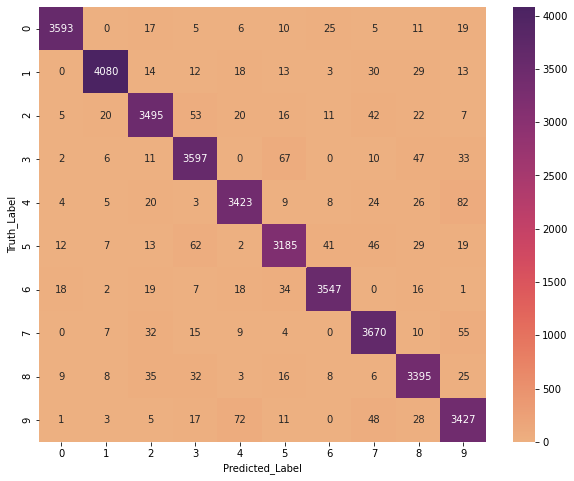

In [326]:
import seaborn as sn
plt.figure(figsize = (10,8))
# were 'cmap' is used to set the accent colour
sn.heatmap(cm6, annot=True, cmap= 'flare',  fmt='d', cbar=True)
plt.xlabel('Predicted_Label')
plt.ylabel('Truth_Label')